In [1]:
## Import libraries
import os
import argparse
import json
import cv2
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.utils import shuffle
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.regularizers import l2, activity_l2
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape

import matplotlib.pyplot as plt
%matplotlib inline

# data paths
session_data = '../simulator-linux/session_data/driving_log.csv'
udacity_data = '../simulator-linux/udacity_data/data/driving_log_edit.csv'
path_prefix = '../simulator-linux/udacity_data/data/'

Using TensorFlow backend.


In [2]:
# reference: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.5dpi87xzi
def augment_brightness(image):
    """
    apply random brightness on the image
    """
    
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    
    # scaling up or down the V channel of HSV
    image[:,:,2] = image[:,:,2]*random_bright
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

In [3]:
def trans_image(image,steer,trans_range, trans_y=False):
    """
    translate image compensate for the translation on the steering angle
    """
    
    rows, cols, chan = image.shape
    
    # horizontal translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    # steer_ang = steer + tr_x*.002
    
    # option to disable lateral translation
    if trans_y:
        tr_y = 40*np.random.uniform()-40/2
    else:
        tr_y = 0
    
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

In [4]:
def crop_image(image, y1, y2, x1, x2):
    """
    crop image into respective size
    give: the crop extent
    """
    return image[y1:y2, x1:x2]

In [5]:
def im_process(image, steer_ang, train=True):
    # image size
    im_y = image.shape[0]
    im_x = image.shape[1]
    
    # new_dim = 64
    
    # translate image and compensate for steering angle
    trans_range = 50
    image, steer_ang = trans_image(image, steer_ang, trans_range) # , trans_y=True
    
    # crop image
    image = crop_image(image, 20, 140, 0+trans_range, im_x-trans_range)
    # image = image[20:140,:]
    # image = image[np.floor(im_y/5):im_y-25, 0:im_x]
    
    # flip image (randomly)
    if np.random.uniform()>= 0.5: #and abs(steer_ang) > 0.1
        image = cv2.flip(image, 1)
        steer_ang = -steer_ang
    
    # augment brightness
    if np.random.uniform()>= 0.3:
        image = augment_brightness(image)
    
    # perturb steering with a bias
    # steer_ang += np.random.normal(loc=0,scale=0.2)
    
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    
#     return np.reshape(image, (1,66,200,3)), steer_ang
    return image, steer_ang
#     return np.reshape(image, (1,im_y,im_x,3)), steer_ang
#     return np.reshape(image, (1,new_dim,new_dim,3)), steer_ang

In [6]:
## data generator
def generate_batch_samples(path, batch_size=128, path_prefix=''):
    while 1:
        batch_x, batch_y = [], []
        
        f = open(path)
        for line in f:
            
            # select image
            data_id = line.split(',')
            cam_view = np.random.choice(['center', 'left', 'right'])
            if cam_view == 'left':
                ## left image
                image = plt.imread(path_prefix+data_id[1].strip())
                image, steering_angle = im_process(image, float(data_id[3])+.25)

            elif cam_view == 'center':
                ## centre image
                image = plt.imread(path_prefix+data_id[0].strip())
                image, steering_angle = im_process(image, float(data_id[3]))

            elif cam_view == 'right':
                ## right image
                image = plt.imread(path_prefix+data_id[2].strip())
                image, steering_angle = im_process(image, float(data_id[3])-.25)
            
            # resize image
            image = cv2.resize(image, (200,66))
            
            batch_x.append(np.reshape(image, (1,66,200,3)))
            batch_y.append(np.array([[steering_angle]]))
            
            if len(batch_x) == batch_size:
                # shuffle batch
                batch_x, batch_y, = shuffle(batch_x, batch_y, random_state=0)
                
                yield (np.vstack(batch_x), np.vstack(batch_y))
                batch_x, batch_y = [], []
    f.close()

def generate_batch_validate(path, batch_size=128, path_prefix=''):
    while 1:
        batch_x, batch_y = [], []
        
        f = open(path)
        for line in f:
            
            data_id = line.split(',')
            cam_view = np.random.choice(['center', 'left', 'right'])

            ## use only center image for validation
            image = plt.imread(path_prefix+data_id[0].strip())
            steering_angle = float(data_id[3])
            image = crop_image(image, 20, 140, 50, 270)
            image = cv2.resize(image, (200,66))
            
            # change colourspace
            image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            
            batch_x.append(np.reshape(image, (1,66,200,3)))
            batch_y.append(np.array([[steering_angle]]))
            
            if len(batch_x) == batch_size:
                yield (np.vstack(batch_x), np.vstack(batch_y))
                batch_x, batch_y = [], []
    f.close()

(66, 200, 3)


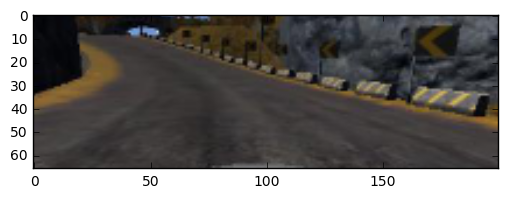

In [7]:
# preview image and preprocess pipeline

# track 1
im_name = '2017_01_21_00_17_08_493.jpg'
image_r = plt.imread("../simulator-linux/session_data/IMG/right_"+im_name)
image_l = plt.imread("../simulator-linux/session_data/IMG/left_"+im_name)
image_c = plt.imread("../simulator-linux/session_data/IMG/center_"+im_name)

# track 2
image_c = plt.imread("../simulator-linux/track_2/IMG/center_2017_01_18_11_28_28_391.jpg")
# steer = 0
# fig = plt.figure()
# aaa = fig.add_subplot(131)
# image_l, steer = im_process(image_l, steer+0.5)
# aaa.imshow(image_l[0])
# plt.xticks([])
# plt.yticks([])
# plt.title('left cam: {0:.2f}'.format(steer))

# steer = 0
# aaa = fig.add_subplot(132)
# image_c, steer = im_process(image_c, steer)
# aaa.imshow(image_c[0])
# plt.xticks([])
# plt.yticks([])
# plt.title('center cam: {0:.2f}'.format(steer))

# steer = 0
# aaa = fig.add_subplot(133)
# image_r, steer = im_process(image_r, steer-0.5)
# aaa.imshow(image_r[0])
# plt.xticks([])
# plt.yticks([])
# plt.title('right cam: {0:.2f}'.format(steer))
# plt.tight_layout()
# show_im = image_c[60:130, 50:250]
# show_im = image_c[20:140,:]
show_im = image_c[20:140,:]
show_im = cv2.resize(show_im, (200,66))
print(show_im.shape)
plt.imshow(show_im)

In [8]:
def commaai_64_model(time_len=1):
    ch, row, col = 3, 64, 64  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

In [9]:
def commaai_model(time_len=1):
    ch, row, col = 3, 100, 220  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

In [10]:
## Model architecture
def nvidia_model(time_len=1):
    ch, row, col = 3, 66, 200  # camera format
    INIT='glorot_uniform' # 'he_normal', glorot_uniform
    keep_prob = 0.2
    reg_val = 0.01
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT, W_regularizer=l2(reg_val)))
    # W_regularizer=l2(reg_val)
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init=INIT))
    model.add(ELU())
    model.add(Dropout(keep_prob))
    
    model.add(Flatten())

    model.add(Dense(100))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(10))
    model.add(ELU())
    
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse") # , metrics=['accuracy']
    
    return model


In [11]:
# try to load a previous json model
model_path = 'nvidia_hsv_glorot_model'

In [ ]:
# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# a callback to save a list of the losses over each batch during training
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))


# a callback to save a list of the accuracies over each batch during training
class AccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.train_acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.train_acc.append(logs.get('acc'))

loss_hist = LossHistory()
acc_hist = AccHistory()
early_stop = EarlyStopping(monitor='val_loss', patience=3, 
                           verbose=0, mode='min')
checkpoint = ModelCheckpoint('checkpoints/'+model_path+'-{epoch:02d}-{val_loss:.4f}', 
                             monitor='val_loss',verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto')

In [ ]:
## Training and validation

EPOCHS = 20

model = nvidia_model()

try:
    model.load_weights(model_path+'.h5')
#     model.load_weights('checkpoints/nvidia_yuv_glorot_model-03-0.0187')
    
except IOError:
    print ('no previous model found....\n')

my_samples_gen = generate_batch_samples(session_data, path_prefix='', batch_size=128)
u_samples_gen = generate_batch_validate(udacity_data, path_prefix=path_prefix, batch_size=200)

# training
model.fit_generator(
    my_samples_gen, # path_prefix=path_prefix,
    samples_per_epoch=128*180, nb_epoch=EPOCHS,
    validation_data=u_samples_gen,
    nb_val_samples=24000,
    callbacks=[early_stop, checkpoint]
) # early_stop, # 72960

print("Saving model weights and configuration file...")

# if not os.path.exists("./outputs/steering_model"):
#     os.makedirs("./outputs/steering_model")

model.save_weights(model_path+'.h5', True)
with open(model_path+'.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

no previous model found....

Epoch 1/20
 2432/23040 [==>...........................] - ETA: 92s - loss: 0.0987